<a href="https://colab.research.google.com/github/smerinobluewin/hello-world/blob/master/brown_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

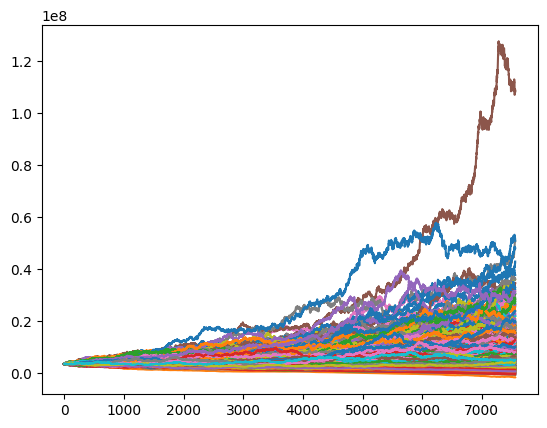

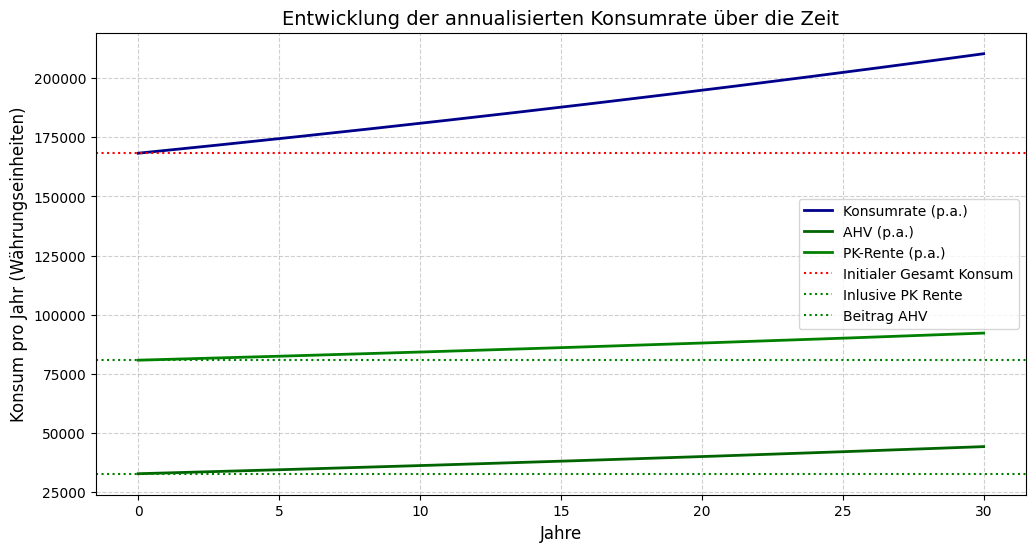

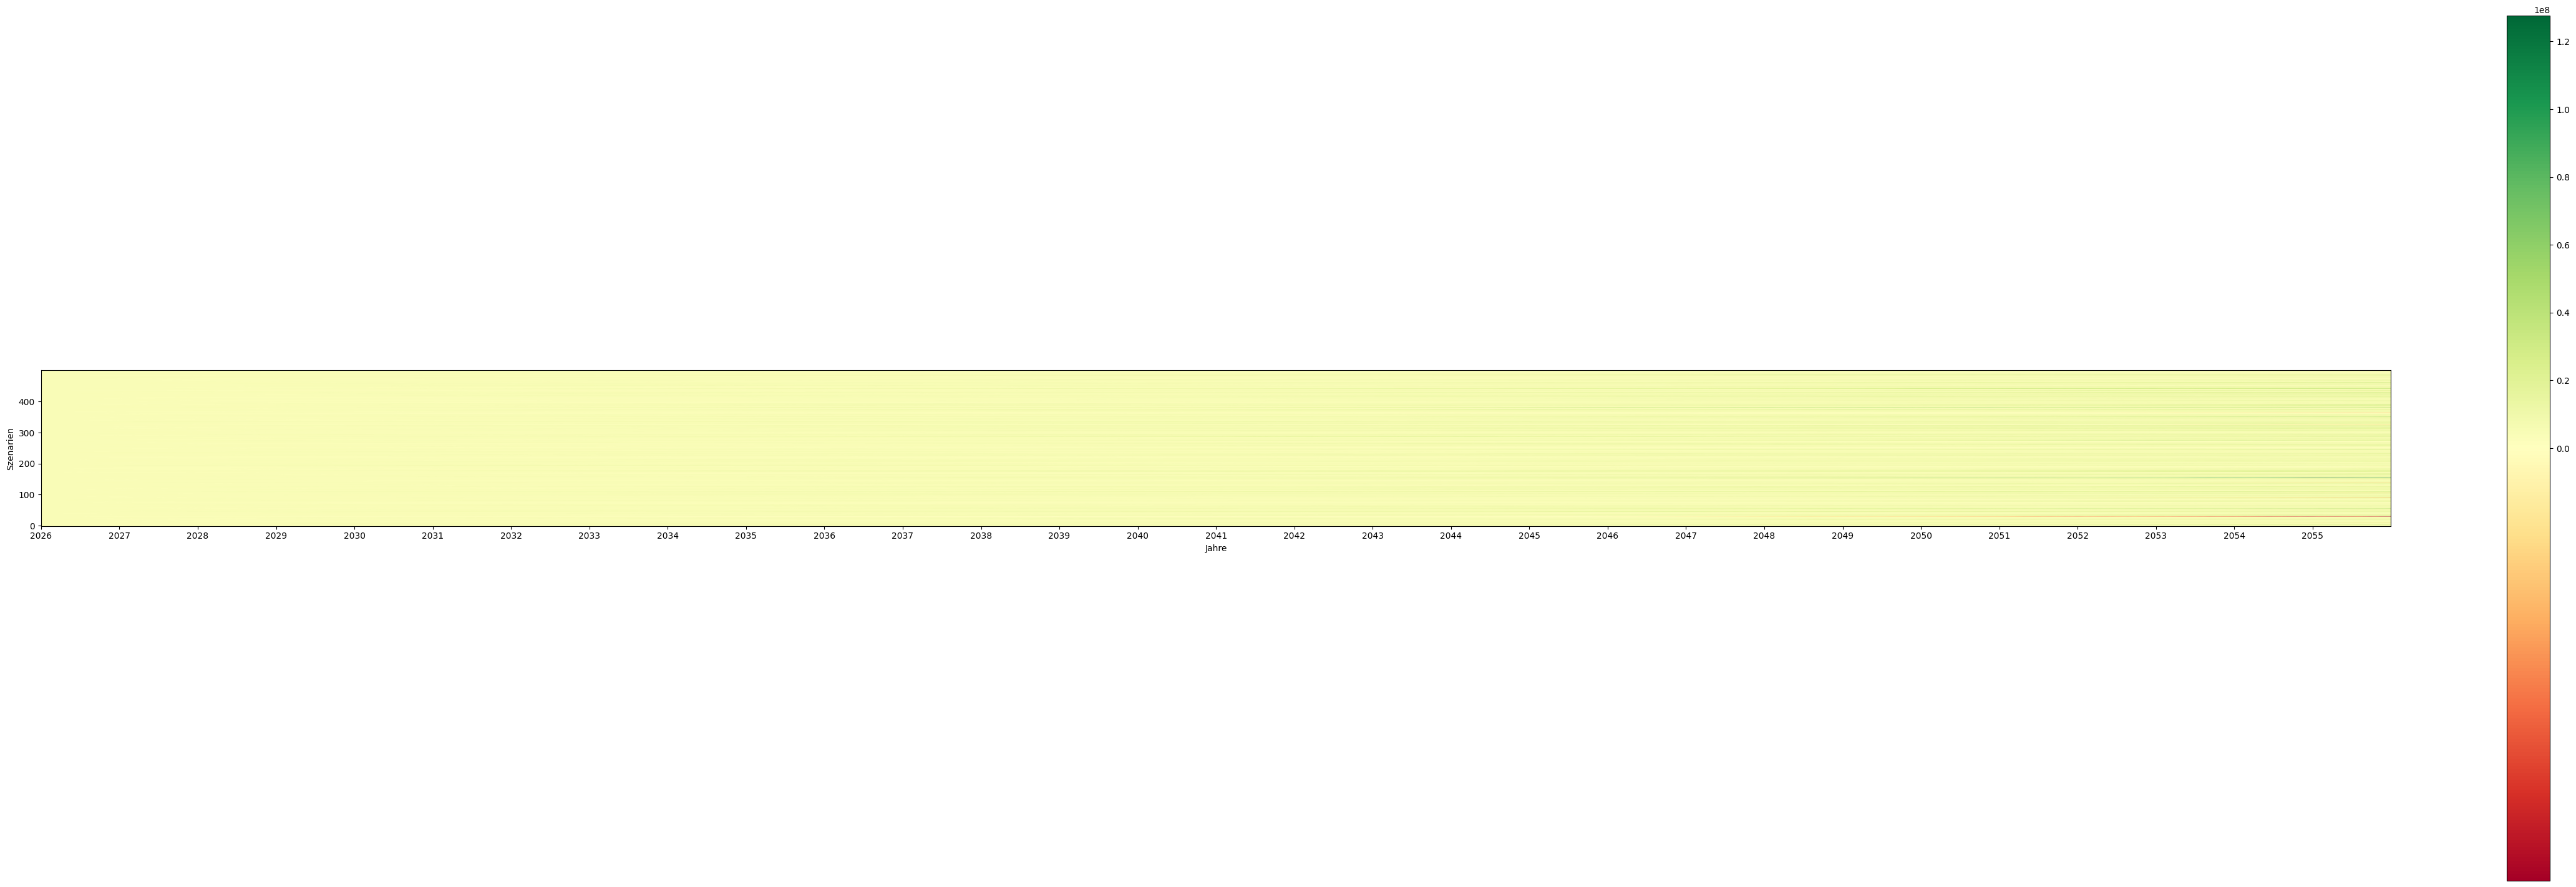

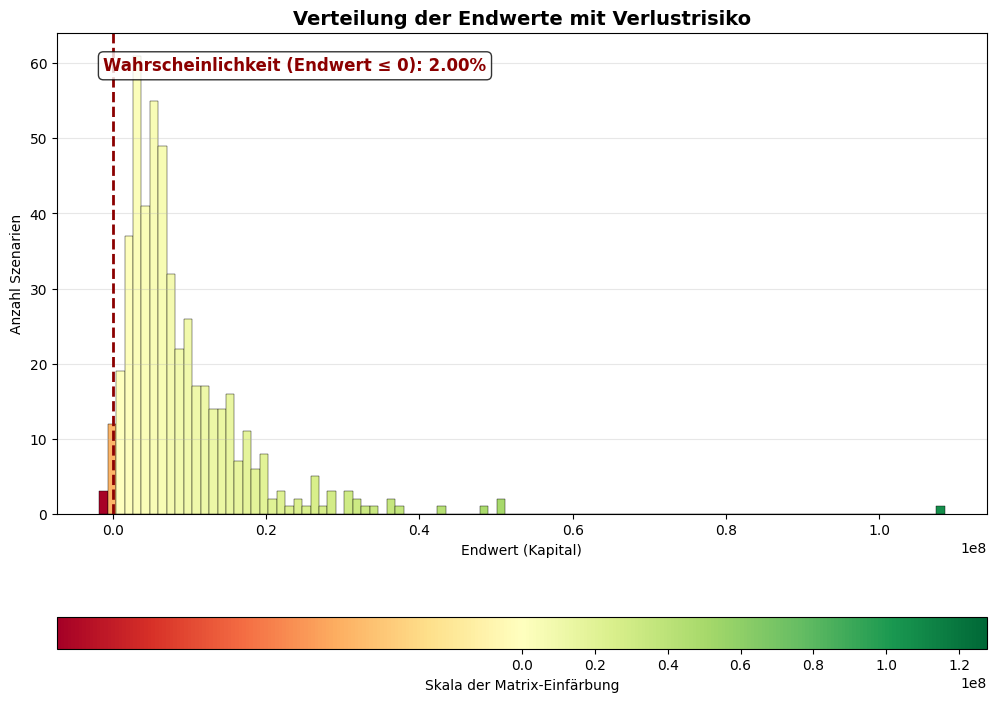

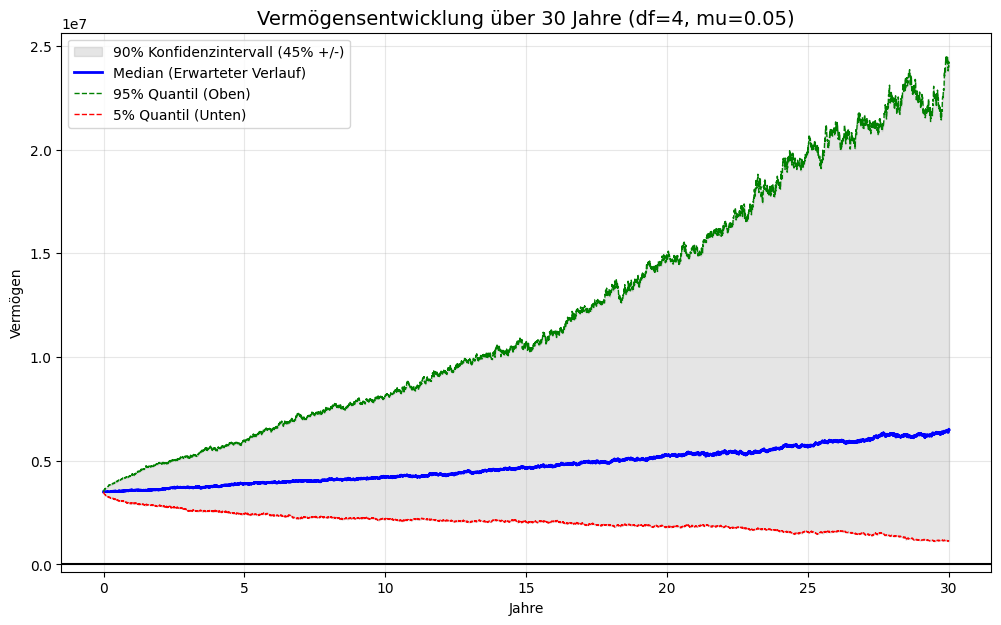

df=4


In [62]:
from PIL.Image import SupportsArrayInterface
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.colors as mcolors


Capital=4500000
PensionCapital=1000000
PensionCapRate=0.048

ConsumptionCapital=Capital-PensionCapital
InflationRate=0.01
ConsumptionRate=0.025
Consumption=ConsumptionRate*ConsumptionCapital

# Renteneinkommen: PK und AHV
PensionIncomeDaily=PensionCapRate*PensionCapital*dt
AHVStartValueDaily=13*2520*dt
AHVIncomeDaily=13*2520*dt

# Anfangs Jahreskonsum Total
ConsumptionTotalAnn=Consumption+(PensionIncomeDaily+AHVIncomeDaily)/dt

# Portfolio Parameter
mu=0.05
sigma=0.11
df=4   # Parameter of t-distribution, smaller 5 equals fat tail, tending to normal distribution if large
HorizonYears=30

Sstart=ConsumptionCapital
S1=Sstart
C=Consumption
Npath=500                     # number of simulation paths
N= HorizonYears*252           # number of time steps (days)
dt=1/252                      # 252 trading days
S1=S1*np.ones((1, Npath))  # initialize row vector of length Npath to build matrix of paths
#S1=np.round(S1,0)
#print(S1)
DATA=-1*np.ones((N,Npath))    # initialize matrix of paths with Npath scenarios of time length N
ConsumptionDaily=np.zeros((N,1)) # initialize row vector of length Npath to build daily consumptiondata
ConsumptionDaily[0,0] = C*dt     # Set the initial daily consumption for day 0

# Speicher für die visualisierte AHV-Rate (optional, falls du sie plotten willst)
AHVHistoryDaily = np.zeros((N, 1))
AHVHistoryDaily[0] = AHVIncomeDaily

#print(DATA)
# St=np.array([S1], dtype=np.float32)

DATA[0, :] = S1
#print(f"{DATA=}")


rng = np.random.default_rng()
t_std_dev = np.sqrt(df / (df - 2))


# HAUPTLOOP
# HAUPTLOOP
for number in range(1, N):
    # 1. Erzeuge standard-normale Zufallszahlen (Zentriert um 0, StdDev 1)
    eps = rng.standard_normal((1, Npath))

    # 2. Asymmetrie einbauen:
    # Wenn eps negativ ist (Markt fällt), ersetzen wir es durch einen t-verteilten Wert
    # Das erzeugt "Fat Tails" nur auf der linken Seite (Verluste)
    mask_negative = eps < 0
    if np.any(mask_negative):
        # Generiere t-verteilte Werte für die negativen Fälle
        neg_t_samples = rng.standard_t(df, size=eps.shape) / t_std_dev
        # Wir nehmen nur die Werte, die auch wirklich negativ sind (linksseitig)
        eps[mask_negative] = -np.abs(neg_t_samples[mask_negative])

    # --- DER FIX: Mittelwert-Korrektur ---
    # Wir ziehen den aktuellen Mittelwert ab, damit E[eps] exakt 0 ist
    eps = eps - np.mean(eps)

    # 3. Exakte GBM-Formel (wie besprochen)
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * eps * np.sqrt(dt)

    S = S1 * np.exp(drift + diffusion) - C * dt
    C=(1+InflationRate*dt)*C
    ConsumptionDaily[number,0] = C*dt

    AHVIncomeDaily=(1+InflationRate*dt)*AHVIncomeDaily
    AHVHistoryDaily[number,0]=AHVIncomeDaily

    DATA[number, :] = S
    S1 = S













"""


for number in range(1, N):

    # Statt standard_normal:
    eps_raw = rng.standard_t(df, size=(1, Npath))

    #df : Freiheitsgrade (5 ist ein guter Kompromiss für Aktienmärkte) oben gesetzt

    # Korrekturfaktor berechnen, damit die Volatilität exakt sigma entspricht
    # Standardabweichung der t-Verteilung = Wurzel(df / (df - 2))
    t_std_dev = np.sqrt(df / (df - 2))


    # 2. Skalieren: Durch eigene StdDev teilen (auf 1 normieren)
    #    und dann mit deiner Ziel-Volatilität verrechnen
    eps = eps_raw / t_std_dev

    # Standard_normal:

    #eps = rng.standard_normal((1, Npath))

    # Exakte GBM Formel für stabilere Pfade
    # Wir berechnen erst die Rendite und wenden sie dann auf S an
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * eps * np.sqrt(dt)

    # S_neu = S_alt * e^(drift + diffusion) - Entnahme
    S = S1 * np.exp(drift + diffusion) - C * dt


    DATA[number, :] = S
    S1 = S
"""











#for number in range(1,N):
#  #print(number)
#  rng=np.random.default_rng()
#  eps=rng.standard_normal((1, Npath)) # Note the tuple for dimensions
  #print(eps)
  #eps=random.normalvariate(mu=0,sigma=1)
#  S=S1+S1*(mu*dt+sigma*eps*np.sqrt(dt)) - C*dt
#  #print(S)
#  DATA[number, :] = S
#  S1=S
  #St=np.column_stack((St,S))

DATA=np.round(DATA,0)
#print(DATA)
#print(f"{DATA=}")
#print(St[1:10])
#print(St[-1])

data=DATA.flatten()
#print(data[1:11])

# Analogous to plot(x) in MATLAB
#plt.plot(DATA[:,1])
#plt.show()


#
# ------  PLOT DER SIMULATIONSPFADE DES VERMOEGENS NACH VERZEHR ABER OHNE RENTE UND AHV denn diese wird täglich voll konsumiert ----
#
plt.plot(DATA)
plt.show()




#  ----- PLOT: Täglicher Konsum als PrüfPlot -----
#TotalConsumptionDaily=ConsumptionDaily+PensionIncomeDaily+AHVIncomeDaily
#plt.figure(figsize=(12, 6))
#plt.plot(TotalConsumptionDaily)
#plt.show()





# --- PLOT: Annualisierte Konsumrate ---

# 1. Berechnung der Rate: Täglicher Konsum * 252 Tage
# ConsumptionDaily hat die Form (N, 1)
TotalConsumptionDaily=ConsumptionDaily+AHVHistoryDaily+PensionIncomeDaily

annualized_consumption_rate = TotalConsumptionDaily * 252
annualized_AHV_consumption_rate = AHVHistoryDaily * 252
annualized_pension_consumption_rate = PensionIncomeDaily*252*np.ones((N, 1))

plt.figure(figsize=(12, 6))

# Zeitachse in Jahren für die X-Achse erstellen
years_axis = np.arange(N) * dt

plt.plot(years_axis, annualized_consumption_rate, color='darkblue', lw=2, label='Konsumrate (p.a.)')
plt.plot(years_axis, annualized_AHV_consumption_rate, color='darkgreen', lw=2, label='AHV (p.a.)')
plt.plot(years_axis, annualized_AHV_consumption_rate + annualized_pension_consumption_rate, color='green', lw=2, label='PK-Rente (p.a.)')


# Optik verfeinern
plt.title('Entwicklung der annualisierten Konsumrate über die Zeit', fontsize=14)
plt.xlabel('Jahre', fontsize=12)
plt.ylabel('Konsum pro Jahr (Währungseinheiten)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Startwert markieren (optional)
plt.axhline(y=ConsumptionTotalAnn, color='red', linestyle=':', label='Initialer Gesamt Konsum')

# Startwert Pension und AHV markieren (optional)
plt.axhline(y=(PensionIncomeDaily+AHVStartValueDaily)/dt, color='green', linestyle=':', label='Inlusive PK Rente')

# Startwert AHV markieren (optional)
plt.axhline(y=AHVStartValueDaily/dt, color='green', linestyle=':', label='Beitrag AHV')

plt.legend()
plt.show()







"""

# HISTOGRAMM DER LETZTEN ZEILE IN DATA
#plt.hist(data, bins=100, color='skyblue', edgecolor='black')

plt.hist(DATA[-1], bins=100, color='skyblue', edgecolor='black')
plt.title("Histogramm der letzten Zeile")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

#plt.imshow(DATA, cmap='viridis', origin='lower') # 'cmap' definiert das Farbschema
#plt.colorbar() # Fügt die Farbskala an der Seite hinzu
#plt.title("2D-Matrix Visualisierung")
#plt.show()

"""



# Beispiel: Werte von -50 bis +100
#data = np.random.uniform(-50, 100, (10, 10))

# Normierung: - SStart ist das Minimum, 0 ist die Mitte (Weiss), Sstart ist das Maximum
minDATA = DATA.min()
maxDATA = DATA.max()

if minDATA <= 0:
    vcenter = 0
else:
    vcenter =0.5*(minDATA+maxDATA)


#print(f"{minDATA}")
#print(f"{maxDATA}")

norm = colors.TwoSlopeNorm(vmin=minDATA, vcenter=vcenter, vmax=maxDATA)
plt.figure(figsize=(60, 180))


# 1. Anzahl der Tage aus den Zeilen von DATA holen
anzahl_tage = DATA.shape[0]
tage_pro_jahr = 252

# 2. Positionen für die Ticks berechnen (0, 252, 504...)
tick_positions = np.arange(0, anzahl_tage, tage_pro_jahr)

# 3. Labels erstellen (z.B. "Jahr 1", "Jahr 2" oder "2024", "2025")
start_jahr = 2026
tick_labels = [str(start_jahr + i) for i in range(len(tick_positions))]

#ax = plt.gca()
# Aktuelle Ticks holen
#ticks = list(ax.get_yticks())
# 1000 hinzufügen, falls nicht vorhanden
#if Npath not in ticks:
#    ticks.append(Npath)
#ax.set_yticks(ticks)


if vcenter == 0:
    if minDATA < 0: # Only use TwoSlopeNorm if there are values below 0
        # Klassisch: Alles unter 0 wird rot (Rd), alles darüber blau (Bu)
        norm = colors.TwoSlopeNorm(vmin=minDATA, vcenter=0, vmax=maxDATA)
        current_cmap = 'RdYlGn'
    else: # If minDATA is 0 and vcenter is 0, use Normalize
        norm = colors.Normalize(vmin=minDATA, vmax=maxDATA)
        current_cmap = 'Greens' # Assuming Greens is desired for non-negative values
else:
    # Wenn vcenter > 0, nutzen wir eine sequentielle Skala (z.B. nur Blau-Töne)
    # oder wir setzen vcenter trotzdem auf 0, um Rot nur für echte Verluste zu zeigen
    norm = colors.Normalize(vmin=minDATA, vmax=maxDATA)
    # Optional: Wechsel zu einer Farbe, die keine "Verlust-Assoziation" hat
    current_cmap = 'Greens'


plt.imshow(DATA.T, cmap= current_cmap, norm=norm, origin='lower')
plt.colorbar(shrink=0.1, fraction=0.15, pad=0.04)

# Ticks auf der X-Achse setzen
plt.xticks(tick_positions, tick_labels)

plt.xlabel("Jahre")
plt.ylabel("Szenarien")
plt.show()



"""

# --- START: Histogramm der Endwerte OHNE Wahrscheinlichkeit negativen Endwert zu erhalten  ---
# Die Werte der letzten Zeile (Endwerte)
final_values = DATA[-1, :]

# 2. Setup für die Farbskala (muss identisch zur Matrix-Visualisierung sein)
vmin, vmax = final_values.min(), final_values.max()
cmap = cm.viridis  # Deine gewählte Colormap
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 3. Plot erstellen
fig, ax = plt.subplots(figsize=(10, 6))

# Histogramm berechnen
n_bins = 100
n, bins, patches = ax.hist(final_values, bins=n_bins, edgecolor='black', linewidth=0.5)

# 4. Jeden Balken basierend auf seiner Position in der Colormap einfärben
for bin_edge, patch in zip(bins, patches):
    color = cmap(norm(bin_edge))
    patch.set_facecolor(color)

# Optik verfeinern
ax.set_title('Verteilung der Endwerte (letzte Zeile)')
ax.set_xlabel('Endwert der Szenarien')
ax.set_ylabel('Häufigkeit')

# Optional: Colorbar hinzufügen, um die Skala zu zeigen
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=ax, orientation='vertical', label='Skalenwert')

plt.show()

"""


# --- START: Histogramm mit Verlustwahrscheinlichkeit (P < 0) ---

# 1. Berechnung der Wahrscheinlichkeit
final_values = DATA[-1, :]
prob_loss = (final_values <= 0).sum() / len(final_values) * 100

# 2. Grafik erstellen
fig, (ax_hist, ax_cb) = plt.subplots(2, 1, figsize=(12, 8),
                                      gridspec_kw={'height_ratios': [15, 1]})
fig.subplots_adjust(hspace=0.4)

# 3. Histogramm plotten und einfärben
n, bins, patches = ax_hist.hist(final_values, bins=100, edgecolor='black', linewidth=0.3)
cmap_obj = plt.get_cmap(current_cmap)

for bin_edge, patch in zip(bins, patches):
    color = cmap_obj(norm(bin_edge))
    patch.set_facecolor(color)

# 4. Markierung der Nulllinie und Wahrscheinlichkeitstext
ax_hist.axvline(x=0, color='darkred', linestyle='--', linewidth=2, label='Null-Linie')

# Textbox für die Wahrscheinlichkeit hinzufügen
textstr = f'Wahrscheinlichkeit (Endwert \u2264 0): {prob_loss:.2f}%'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax_hist.text(0.05, 0.95, textstr, transform=ax_hist.transAxes, fontsize=12,
             verticalalignment='top', bbox=props, color='darkred', fontweight='bold')

# Optik Histogramm
ax_hist.set_title("Verteilung der Endwerte mit Verlustrisiko", fontsize=14, fontweight='bold')
ax_hist.set_xlabel("Endwert (Kapital)")
ax_hist.set_ylabel("Anzahl Szenarien")
ax_hist.grid(axis='y', alpha=0.3)

# 5. Separate Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_obj, norm=norm)
cb = fig.colorbar(sm, cax=ax_cb, orientation='horizontal')
cb.set_label('Skala der Matrix-Einfärbung')

plt.show()





# --- START: Plot Erwartungswert und Quantil-Bänder ---

# 1. Statistische Kennzahlen über alle Pfade berechnen (Achse 1 = Scenarios)
expected_value = np.median(DATA, axis=1) # Median ist robuster als Mean bei Fat Tails
upper_quantile = np.percentile(DATA, 95, axis=1) # 45% nach oben vom Median (ca. 95%)
lower_quantile = np.percentile(DATA, 5, axis=1)  # 45% nach unten vom Median (ca. 5%)

# 2. Zeitachse in Jahren für den Plot erstellen
jahre_achse = np.linspace(0, 30, N)

plt.figure(figsize=(12, 7))

# Den Bereich zwischen den Quantilen farbig füllen (Transparenz mit alpha)
plt.fill_between(jahre_achse, lower_quantile, upper_quantile,
                 color='gray', alpha=0.2, label='90% Konfidenzintervall (45% +/-)')

# Die Linien zeichnen
plt.plot(jahre_achse, expected_value, color='blue', lw=2, label='Median (Erwarteter Verlauf)')
plt.plot(jahre_achse, upper_quantile, color='green', lw=1, linestyle='--', label='95% Quantil (Oben)')
plt.plot(jahre_achse, lower_quantile, color='red', lw=1, linestyle='--', label='5% Quantil (Unten)')

# Nulllinie markieren
plt.axhline(0, color='black', lw=1.5)

# Optik
plt.title(f"Vermögensentwicklung über 30 Jahre (df={df}, mu={mu})", fontsize=14)
plt.xlabel("Jahre")
plt.ylabel("Vermögen")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Optional: Y-Achse begrenzen, falls Ausreißer den Plot stauchen
plt.ylim(bottom=-0.1 * Sstart)

plt.show()







print(f"{df=}")







#sns.heatmap(DATA, annot=True, cmap='YlGnBu')
#plt.show()

#plt.hist(data, bins=100, color='skyblue', edgecolor='black')
#plt.title("Mein erstes Histogramm")
#plt.xlabel("Werte")
#plt.ylabel("Häufigkeit")
#plt.show()